# Predicting Banknote Authenticity
This dataset was composed from images of authentic and fraudulent banknotes. This dataset was taken from the UCI Machine Learning Repository and is available [here](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). The features are metrics taken from wavelet analysis of the images. The goal of this project is to identify clusters in the data that can be used to distinguish authentic and fraudulent banknotes. 

In [1]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import warnings
warnings.filterwarnings('ignore')

import helpers as hp

%matplotlib inline

## Load Dataset
Read the dataset into a Pandas `DataFrame`. The csv file does not contain any header information, so I added in the column names by hand.

In [2]:
df = pd.read_csv('./data/data_banknote_authentication.csv', header=None, 
                 names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])

Make a list of the features in this dataset.

In [3]:
features = ['variance', 'skewness', 'curtosis', 'entropy']

## Data Exploration
Let's explore this dataset. We can first view some of it's properties by using `describe()`.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
variance,1372.0,0.433735,2.842763,-7.0421,-1.773000,0.49618,2.821475,6.8248
skewness,1372.0,1.922353,5.869047,-13.7731,-1.708200,2.31965,6.814625,12.9516
curtosis,1372.0,1.397627,4.310030,-5.2861,-1.574975,0.61663,3.179250,17.9274
entropy,1372.0,-1.191657,2.101013,-8.5482,-2.413450,-0.58665,0.394810,2.4495
class,1372.0,0.444606,0.497103,0.0000,0.000000,0.00000,1.000000,1.0000


All of the feature values are roughly in the same range. 

_class_ is the target variable and it only consists of 1s and 0s. Notice that the mean is less than 0.5 and 50% is 0. This is an indicator that there is an imbalance in each class.

### Class imbalance
Let's explore the class imbalance a little further and correct for it. The clustering models I will use will perform better if there is equal representation of each class.

In [5]:
df['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

In [6]:
classes = df['class'].value_counts().index.tolist()
value_counts = df['class'].value_counts().values
for i, j in zip(classes, value_counts):
    print(f'There are {j} values for class {i}.')

There are 762 values for class 0.
There are 610 values for class 1.


There are more value of class 0 than class 1. I will use `SMOTE` to upsample the dataset to make it balanced.

In [7]:
X = df.loc[:, features].values
y = df['class'].values

In [8]:
X_upsampled, y_upsampled = SMOTE().fit_resample(X, y)

In [9]:
pd.Series(y_upsampled).value_counts()

1    762
0    762
dtype: int64

Great! Now I have balanced classes.

I will create a new `DataFrame` with these upsampled values and use it for analysis.

In [10]:
upsampled = np.hstack((X_upsampled, y_upsampled.reshape(-1,1)))

In [11]:
df_model = pd.DataFrame(upsampled, columns=['variance', 'skewness', 'curtosis', 'entropy', 'class'])

In [12]:
df_model.describe().T

,count,mean,std,min,25%,50%,75%,max
variance,1524.0,0.201143,2.845136,-7.0421,-1.955200,0.158905,2.551700,6.8248
skewness,1524.0,1.589614,5.922488,-13.7731,-2.184122,1.978250,6.397150,12.9516
curtosis,1524.0,1.511767,4.441521,-5.2861,-1.543700,0.576365,3.465825,17.9274
entropy,1524.0,-1.196297,2.103061,-8.5482,-2.426050,-0.594405,0.387700,2.4495
class,1524.0,0.500000,0.500164,0.0000,0.000000,0.500000,1.000000,1.0000


### Variable distributions
Let's take a look at the distributions for each feature in the dataset.

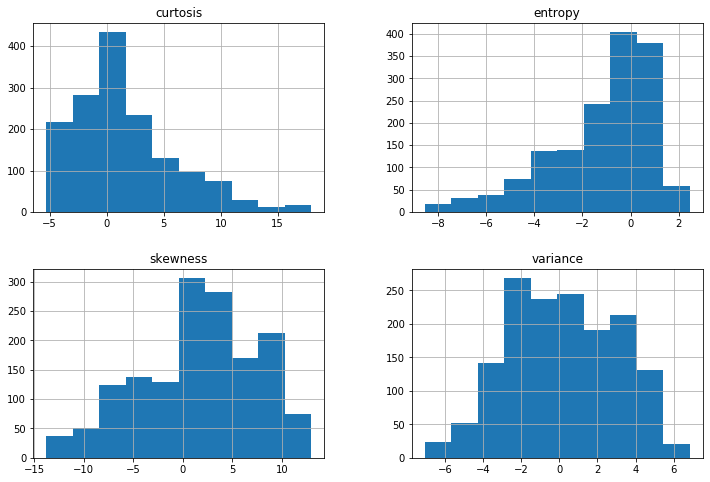

In [13]:
df_model.loc[:, features].hist(bins=10, figsize=(12, 8))
plt.savefig('./images/feature_distributions.png')
plt.show()

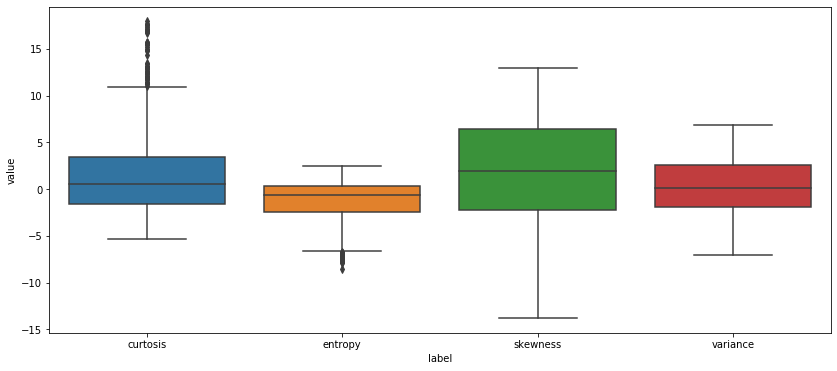

In [15]:
hp.create_boxplots(df_model, features, filename='wavelet_boxplots')

_curtosis_ and _entropy_ are highly skewed. They also show outliers in the box plots, which makes sense because of the skewness.

### Box-Cox Transformation
I will correct for the skewness using a Box-Cox transformation.

In [16]:
skewed = ['curtosis', 'entropy']
boxcoxed = [f'{x}_bc' for x in skewed]
hp.apply_transform(df_model, skewed, 'boxcox')

In [17]:
updated_features = ['skewness', 'variance']
updated_features += boxcoxed

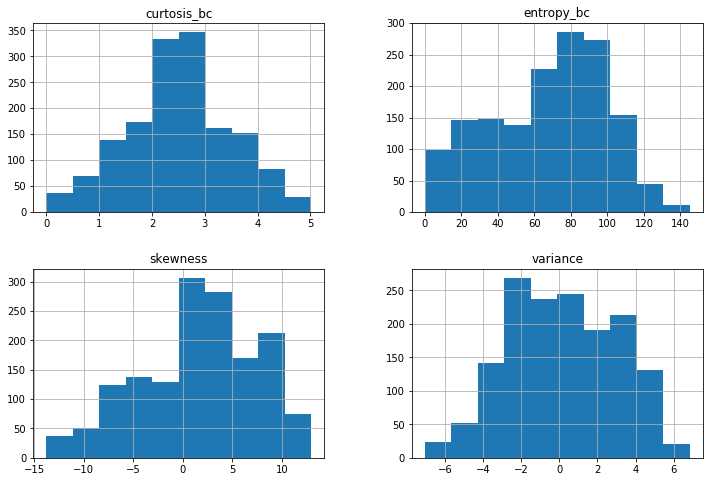

In [18]:
df_model.loc[:, updated_features].hist(bins=10, figsize=(12, 8))
plt.savefig('./images/feature_distributions_boxcoxed')
plt.show()

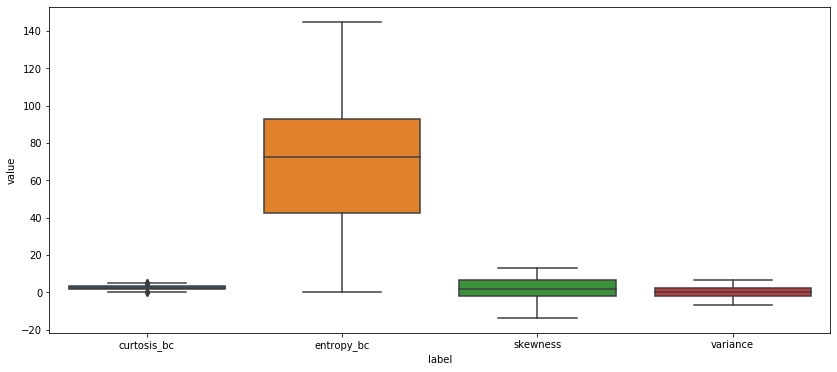

In [19]:
hp.create_boxplots(df_model, updated_features, filename='boxcoxed_boxplots')

The skewness looks better, but there is a wide range in values between the variables.
### Normalization
Here, I normalized the features so that they are on the same scale.

In [20]:
normalized = [f'{x}_nm' for x in updated_features]
hp.apply_transform(df_model, updated_features, 'normalize')

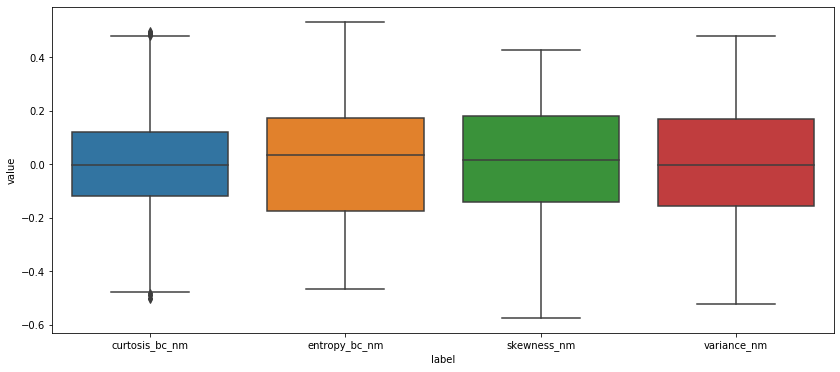

In [21]:
hp.create_boxplots(df_model, normalized, filename='normalized_boxcoxed_boxplots')

### Outliers
As seen in the box plot above, _curtosis_ is the only variable that shows outliers. I will correct for the outliers using the Tukey method.

In [22]:
tukeyed = ['curtosis_bc_nm_tk']
hp.correct_outliers(df_model, ['curtosis_bc_nm'])

In [23]:
updated_features = normalized
updated_features.remove('curtosis_bc_nm')
updated_features.append('curtosis_bc_nm_tk')

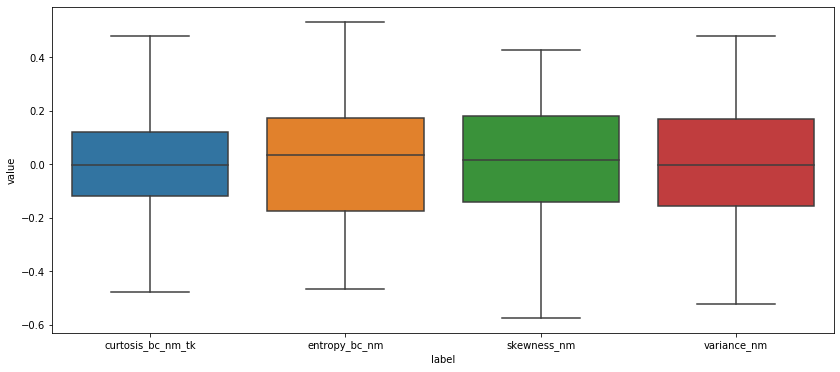

In [24]:
hp.create_boxplots(df_model, updated_features, filename='tukeyed_boxplots')

## Feature Engineering
### PCA
I will reduce the feature space using PCA. I will then compare finding clusters using the components of PCA with finding clusters using the actual dataset features.

In [25]:
hp.perform_pca(df_model, updated_features, 3)

Variance Explained:
 * component 1: 55.0%
 * component 2: 31.4%
 * component 3: 7.8%
 * total: 94.2%


The first three components explain up to 94% of the variance. Components 1 and 2 explain 55% and 31% of the variance, respectively.
## Data Exploration
### T-Test
Since the goal of this project is to identify fraud, I would like to know how different each class is for each feature. For example, given the feature _curtosis_ , I want to know if the distribution in _curtosis_ values when _class_ equals 0.0 is different from the distribution in _cutosis_ values when _class_ equals 1.0. The difference in these distributions can be performed by using a T-test, which I will do on each feature.

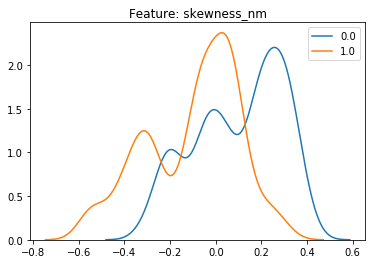

T-Test Results for skewness_nm:
 * t-stat: 19.684
 * p-value: 4.994e-77


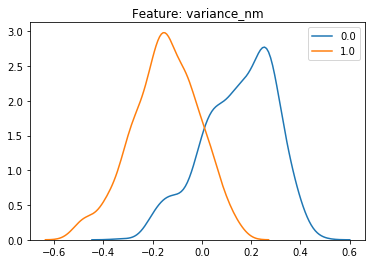

T-Test Results for variance_nm:
 * t-stat: 41.639
 * p-value: 1.353e-253


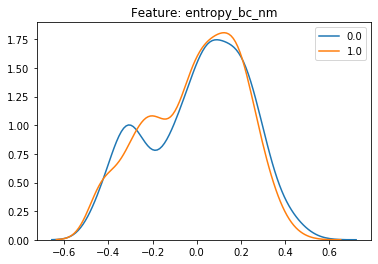

T-Test Results for entropy_bc_nm:
 * t-stat: 1.225
 * p-value: 2.209e-01


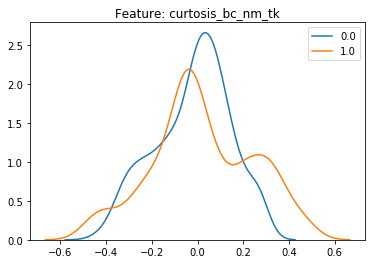

T-Test Results for curtosis_bc_nm_tk:
 * t-stat: -4.094
 * p-value: 4.463e-05


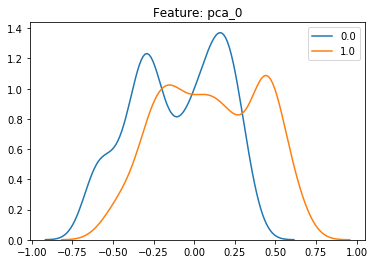

T-Test Results for pca_0:
 * t-stat: -13.833
 * p-value: 4.424e-41


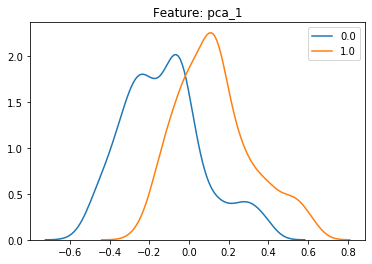

T-Test Results for pca_1:
 * t-stat: -25.381
 * p-value: 8.392e-119


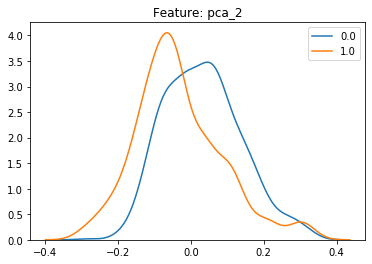

T-Test Results for pca_2:
 * t-stat: 11.379
 * p-value: 7.476e-29


In [26]:
for feature in updated_features:
    filename = f'{feature}_distribution'
    hp.ttest_feature(df_model, feature, filename=filename)

The p-value for _entropy_ is high, greater than 0.2, indicating there is no difference in entropy values between each class. 

The p-values for _curtosis_ is also high, compared to the values for the other features.

All p-values for the principal components are low.
## Modeling
I will perform a K-means and spectral clustering for a few different scenarios.
### Model 1: PCA Components
Let's begin by only fitting models to the principle components.

In [27]:
X = df_model.loc[:, ['pca_0', 'pca_1', 'pca_2']]
y = df_model['class']

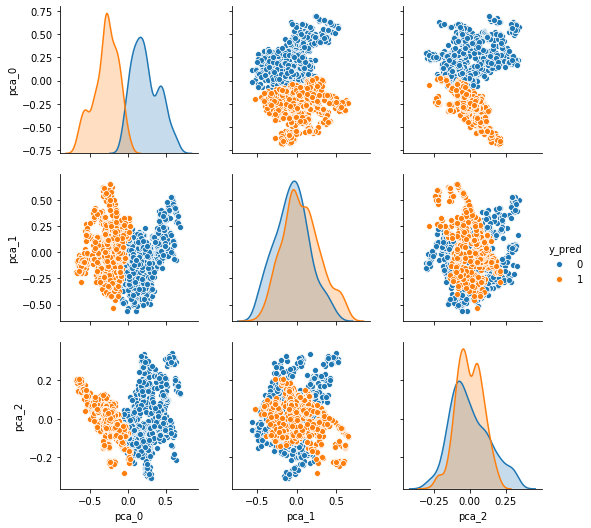

Contingency Table
actual       0    1
predicted          
0.0        374  388
1.0        460  302
ARI: 0.012


In [28]:
hp.fit_kmeans(X, y, 2, evaluate_model=True, filename='pca_kmeans_pair_plot')

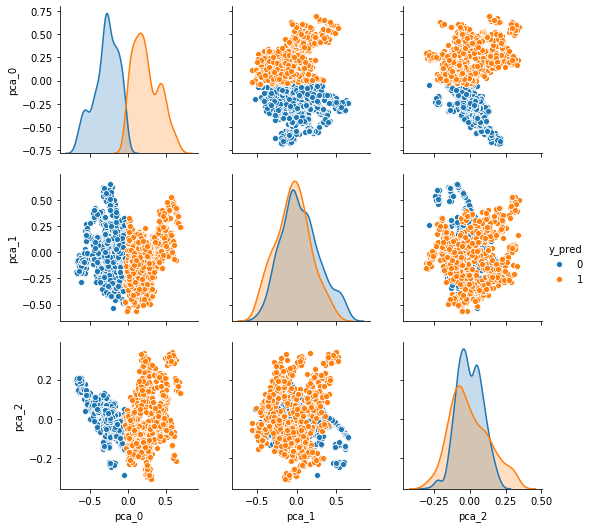

Contingency Table
actual       0    1
predicted          
0.0        410  352
1.0        293  469
ARI: 0.023


In [29]:
hp.fit_spectral_clustering(X, y, 2, evaluate_model=True, 
                           filename='pca_spectral_clustering_pair_plot')

Both clustering algorithms do not perform well using the principle components. The ARI score is close to zero and there are roughly equal numbers in each box of the contingency table.
### Model 2: All Features
Let's try using the features in the dataset to find clusters.

In [30]:
updated_features = ['skewness_nm', 'variance_nm', 'entropy_bc_nm', 'curtosis_bc_nm_tk']
print(f'The features are: {updated_features}')

The features are: ['skewness_nm', 'variance_nm', 'entropy_bc_nm', 'curtosis_bc_nm_tk']


In [31]:
X = df_model.loc[:, updated_features]
y = df_model['class']

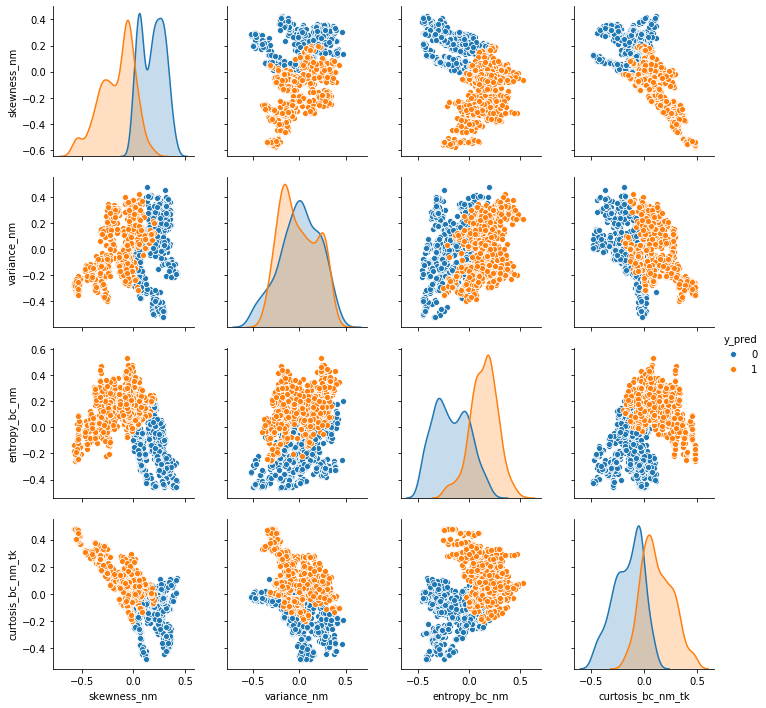

Contingency Table
actual       0    1
predicted          
0.0        388  374
1.0        302  460
ARI: 0.012


In [32]:
hp.fit_kmeans(X, y, 2, evaluate_model=True, filename='features_kmeans_pair_plot')

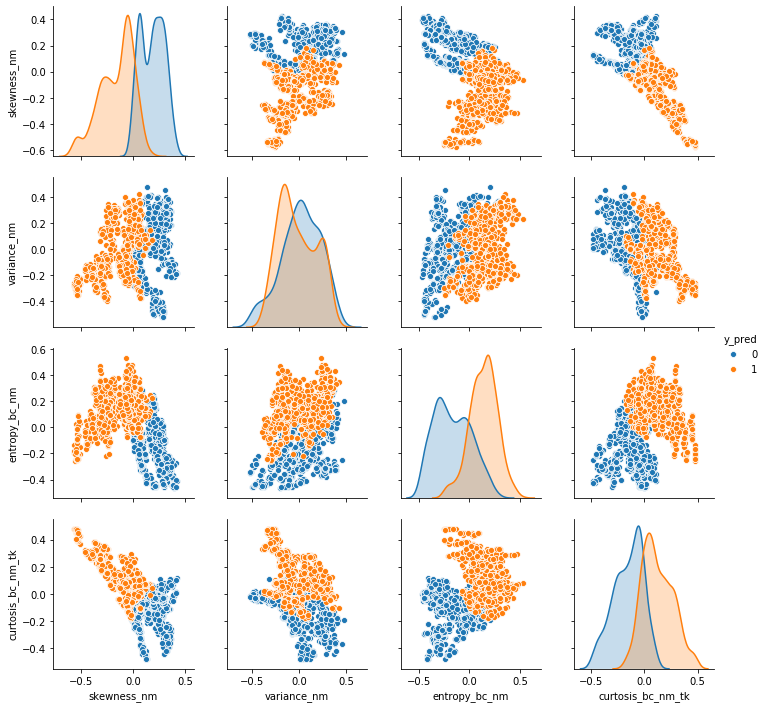

Contingency Table
actual       0    1
predicted          
0.0        410  352
1.0        291  471
ARI: 0.024


In [33]:
hp.fit_spectral_clustering(X, y, 2, evaluate_model=True, 
                           filename='features_spectral_clustering_pair_plot')

Again, there is a poor fit. Just like with the PCA components, there is a low ARI value on roughly equal numbers in each box of the contingency tables. But, remember that these features include two that do not provide that much information related to the different classes, _entropy_ and _curtosis_. Let's remove these two features and repeat the model fits.
### Model 3: Only _skewness_ and _variance_ features

In [34]:
feature_subset = ['skewness_nm', 'variance_nm']
print(f'The features are: {feature_subset}')

The features are: ['skewness_nm', 'variance_nm']


In [35]:
X = df_model.loc[:, feature_subset]
y = df_model['class']

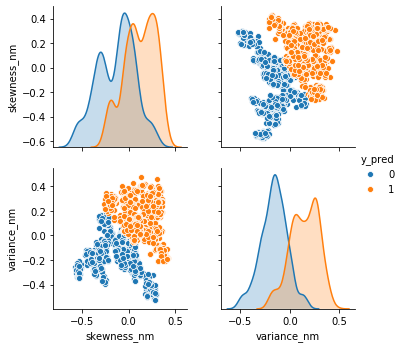

Contingency Table
actual       0    1
predicted          
0.0         85  677
1.0        647  115
ARI: 0.544


In [36]:
hp.fit_kmeans(X, y, 2, evaluate_model=True, filename='two_features_kmeans_pair_plot')

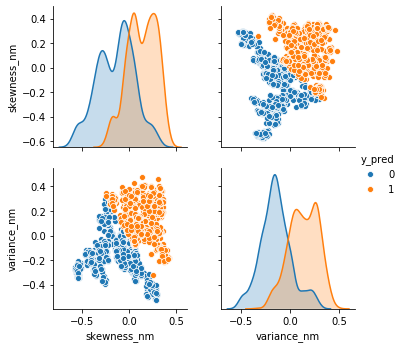

Contingency Table
actual       0    1
predicted          
0.0        125  637
1.0        636  126
ARI: 0.449


In [37]:
hp.fit_spectral_clustering(X, y, 2, evaluate_model=True, 
                           filename='two_features_spectral_clustering_pair_plot')

Great! Both models are doing a better job at finding clusters. In each case, the ARI score is much higher than in the previous models, all though it is still not too close to 1. Also, the K-means models seems to identify the clusters backwards as there are more false positives than true positives and false negatives than true negatives.
## Conclusions
In conclusion, I was able to create models that can correctly cluster fraudulent and authentic banknotes given image features of each banknote. The best features to use are _skewness_ and _variance_. Spectral clustering proved to be the best algorithm as it split that data into clusters and accurately labeled them with each class. While K-means also split the data into clusters, it reversed the classes for each cluster assignment.